# Importaciones

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [2]:
# Kaggle: https://www.kaggle.com/datasets/shivam2503/diamonds
# Origen: Tiffany & Co's snapshot pricelist from 2017
df_base = pd.read_csv(r'..\data\raw\raw_diamonds.csv')


# Observaciones iniciales

In [3]:
df_base.head()


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
# Adaptamos los nombres de las columnas para que sean legibles y borramos la primera porque no sirve

df_base = df_base.drop(columns='Unnamed: 0')

df_base = df_base.rename(columns={'carat': 'weight (carat)',
                                                'cut': 'cut quality',
                                                'color': 'color quality',
                                                'clarity': 'clarity quality', # Fuente: https://4cs.gia.edu/en-us/diamond-clarity/
                                                'depth': 'depth (percentage)', # Medida de la altura ("depth") del diamante en relación a su diámetro. Fuente: https://www.withclarity.com/education/diamond-education/diamond-cut/what-is-diamond-depth-or-diamond-education
                                                'table': 'table (percentage)', # Medida de la parte plana ("table") del diamante en relación a su diámetro. Fuente: https://www.brilliance.com/education/diamonds/depth-table
                                                'price': 'price (dollars)',
                                                'x': 'lenght (millimeters)', # Visto desde arriba, longitud de un costado del diamante. Su media con "width" da el diámetro
                                                'y': 'width (millimeters)', # Visto desde arriba, longitud del otro costado
                                                'z': 'depth (millimeters)' # Altura (distancia entre la punta y la parte plana)
                                                }
                                )


In [5]:
df_base.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [6]:
# No hay valores nulos
df_base.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weight (carat)        53940 non-null  float64
 1   cut quality           53940 non-null  object 
 2   color quality         53940 non-null  object 
 3   clarity quality       53940 non-null  object 
 4   depth (percentage)    53940 non-null  float64
 5   table (percentage)    53940 non-null  float64
 6   price (dollars)       53940 non-null  int64  
 7   lenght (millimeters)  53940 non-null  float64
 8   width (millimeters)   53940 non-null  float64
 9   depth (millimeters)   53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [7]:
# No parece posible que haya diamantes con 0 milimetros de altura, anchura o profundidad. Quizá lo que ocurra es que son tan redondos que no cabe medir algunos datos. Habrá que revisarlo
df_base.describe()


,weight (carat),depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [8]:
df_base.describe(include='object')


,cut quality,color quality,clarity quality
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


In [9]:
# Hay muchos valores duplicados
df_base[df_base.duplicated()]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)
1005,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1006,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1007,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1008,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
2025,1.52,Good,E,I1,57.3,58.0,3105,7.53,7.42,4.28
...,...,...,...,...,...,...,...,...,...,...
47969,0.52,Ideal,D,VS2,61.8,55.0,1919,5.19,5.16,3.20
49326,0.51,Ideal,F,VVS2,61.2,56.0,2093,5.17,5.19,3.17
49557,0.71,Good,F,SI2,64.1,60.0,2130,0.00,0.00,0.00
50079,0.51,Ideal,F,VVS2,61.2,56.0,2203,5.19,5.17,3.17


In [10]:
# Hay que eliminar los duplicados. Copiamos el "dataframe" para poder trabajar con varias versiones si conviene
df_diamonds = df_base.copy().drop_duplicates()
df_diamonds[df_diamonds.duplicated()]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)


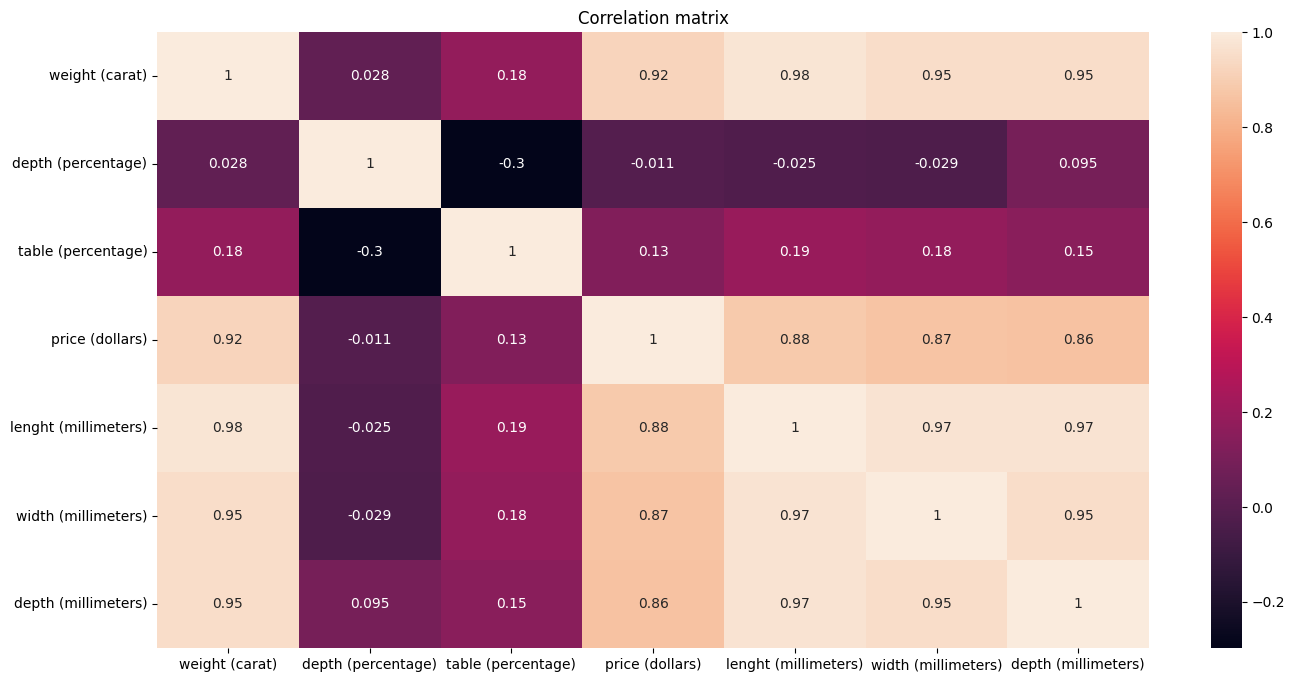

In [11]:
# Hacemos una correlación preeliminar (sin análisis) que nos servirá para detectar errores, si los hay, durante la limpieza
plt.rc("figure", figsize=(16, 8))

corr = df_diamonds.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [12]:
plt.rc("figure", figsize=(6.4, 4.8))


# Desglose por columnas

## weight (carat)

In [13]:
df_diamonds['weight (carat)'].unique()


array([0.23, 0.21, 0.29, 0.31, 0.24, 0.26, 0.22, 0.3 , 0.2 , 0.32, 0.33,
       0.25, 0.35, 0.42, 0.28, 0.38, 0.7 , 0.86, 0.71, 0.78, 0.96, 0.73,
       0.8 , 0.75, 0.74, 0.81, 0.59, 0.9 , 0.91, 0.61, 0.77, 0.63, 0.76,
       0.64, 0.72, 0.79, 0.58, 1.17, 0.6 , 0.83, 0.54, 0.98, 0.52, 1.01,
       0.53, 0.84, 0.51, 1.05, 0.55, 0.87, 1.  , 0.57, 0.82, 1.04, 0.93,
       1.2 , 0.99, 0.34, 0.43, 0.36, 0.95, 0.89, 1.02, 0.97, 0.56, 0.85,
       0.92, 1.27, 0.66, 1.12, 0.68, 1.03, 0.62, 1.22, 1.08, 0.88, 0.5 ,
       1.19, 0.39, 0.65, 1.24, 1.5 , 0.27, 0.41, 1.13, 1.06, 0.69, 0.4 ,
       1.14, 0.94, 1.29, 1.52, 1.16, 1.21, 1.23, 1.09, 0.67, 1.11, 1.1 ,
       1.18, 1.15, 1.25, 1.07, 1.28, 1.51, 0.37, 1.31, 1.26, 1.39, 1.44,
       1.35, 1.3 , 1.32, 1.41, 1.36, 1.45, 1.34, 1.58, 1.54, 1.38, 1.33,
       1.74, 1.64, 1.47, 1.4 , 1.55, 1.95, 2.  , 1.37, 1.83, 1.62, 1.57,
       1.69, 2.06, 1.72, 1.66, 2.14, 1.49, 1.46, 2.15, 1.96, 2.22, 1.7 ,
       1.53, 1.85, 2.01, 2.27, 1.68, 1.56, 1.81, 1.

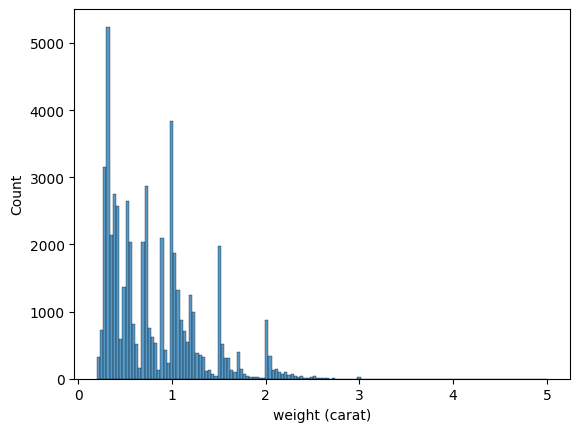

In [14]:
# Hay muy pocos diamantes que pesen más de 2 "carat" (quilates)
sns.histplot(df_diamonds['weight (carat)'])
plt.show()


In [15]:
# No hay valores que sean cero
df_diamonds[df_diamonds['weight (carat)'] == 0] 


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)


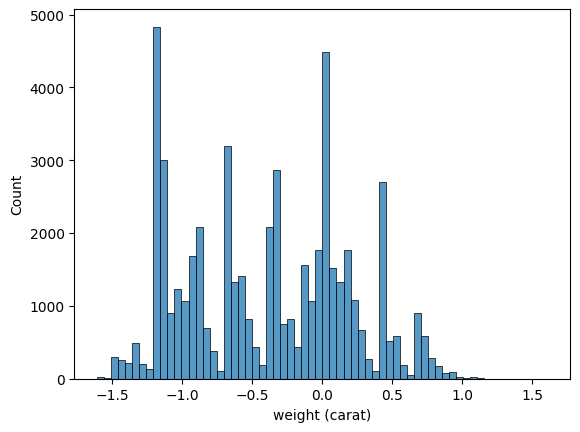

In [16]:
# Está muy a la izquierda. Utilizamos el logaritmo para centrarlo
df_diamonds['weight (carat)'] = np.log(df_diamonds['weight (carat)'])

sns.histplot(df_diamonds['weight (carat)'])
plt.show()


### "Outliers" tratados

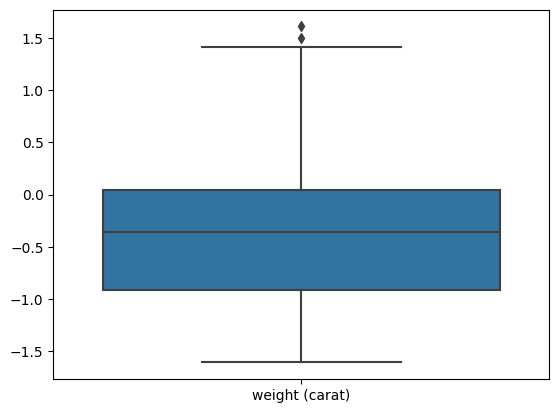

In [17]:
# Confirmamos con un boxplot que quedan solo un par de valores atípicos
ax = sns.boxplot(df_diamonds['weight (carat)'])
ax.set_xticklabels(['weight (carat)'])
plt.show()


In [18]:
# Como están cerca del máximo del boxplot, los imputamos a esa cifra
q3, q1 = np.percentile(df_diamonds['weight (carat)'], [75, 25])
iqr = q3 - q1

df_diamonds.loc[df_diamonds['weight (carat)'] > q3 + 1.5*iqr, 'weight (carat)'] = q3 + 1.5*iqr


## cut quality

In [19]:
# No es numérica, habrá que transformarla. 
cut_uniques = list(df_diamonds['cut quality'].unique())
cut_uniques


['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']

In [20]:
# Utilizamos valores cercanos a 0 para que, al tipificar otras columnas, no se alejen demasiado
very_good = cut_uniques[3]
cut_uniques.remove(very_good)
cut_uniques.insert(2, very_good)

for word, value in zip(reversed(cut_uniques), [-1.0, -0.5, 0.0, 0.5, 1.0]):
    df_diamonds.loc[df_diamonds['cut quality'] == word, 'cut quality'] = value
    print(word, value)


Fair -1.0
Good -0.5
Very Good 0.0
Premium 0.5
Ideal 1.0


In [21]:
df_diamonds['cut quality'] = df_diamonds['cut quality'].astype(float)

df_diamonds['cut quality'].unique()


array([ 1. ,  0.5, -0.5,  0. , -1. ])

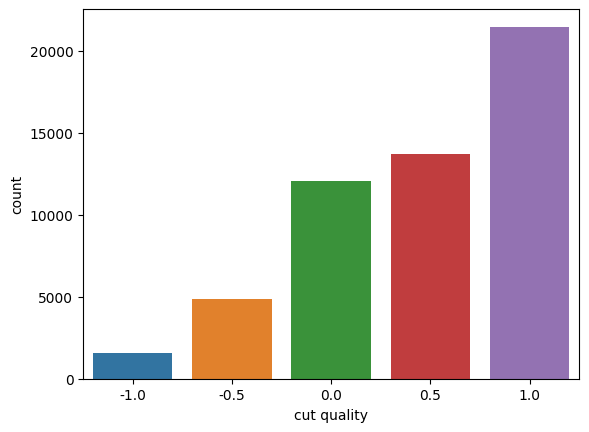

In [22]:
# Están bastente repartidos, aunque hay menos de categoría "Good" (-0.5) o inferior
sns.countplot(x=df_diamonds['cut quality'])
plt.show()


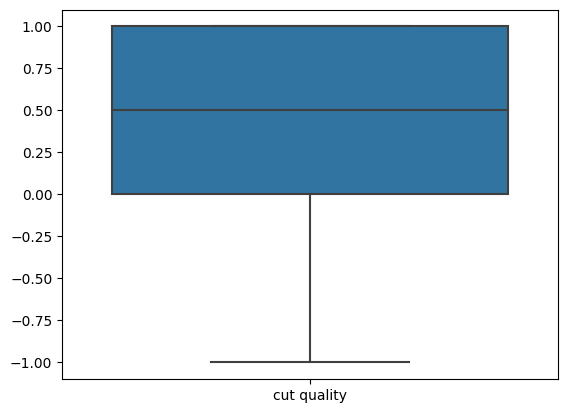

In [23]:
# En efecto, no hay "outliers"
ax = sns.boxplot(df_diamonds['cut quality'])
ax.set_xticklabels(['cut quality'])
plt.show()


## color quality

In [24]:
color_uniques = list(df_diamonds['color quality'].unique())
color_uniques.sort(reverse=True)
color_uniques


['J', 'I', 'H', 'G', 'F', 'E', 'D']

In [25]:
# Similar al anterior, hay que pasar los valores a numéricos (J es la peor calidad, y D es la mejor)
for character, value in zip(color_uniques, [-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]):
    df_diamonds.loc[df_diamonds['color quality'] == character, 'color quality'] = value
    print(character, value)


J -1.5
I -1.0
H -0.5
G 0.0
F 0.5
E 1.0
D 1.5


In [26]:
df_diamonds['color quality'] = df_diamonds['color quality'].astype(float)

df_diamonds['color quality'].unique()


array([ 1. , -1. , -1.5, -0.5,  0.5,  0. ,  1.5])

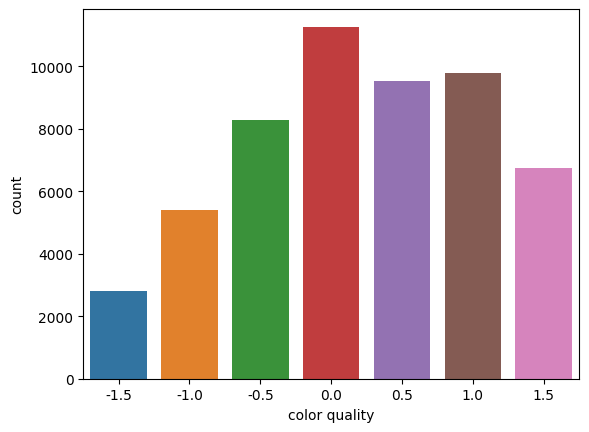

In [27]:
# Están repartidos, si bien hay pocos de calidad J (-1.5)
sns.countplot(x=df_diamonds['color quality'])
plt.show()


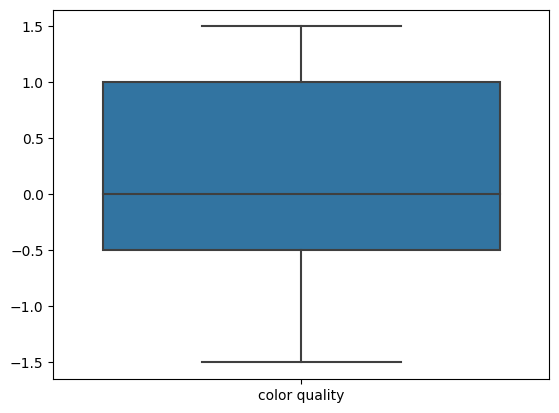

In [28]:
# Sin valores atípicos
ax = sns.boxplot(df_diamonds['color quality'])
ax.set_xticklabels(['color quality'])
plt.show()


## clarity quality

In [29]:
# Hay que buscar a qué nivel de calidad corresponde cada valor y numerarlos
df_diamonds['clarity quality'].unique()


array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

In [30]:
# Fuente: https://www.77diamonds.com/es/grados-de-pureza-del-diamante
df_diamonds['clarity quality'] = df_diamonds['clarity quality'].apply(lambda x: -1.5 if x == 'I1'
                                                                        else -1.0 if x == 'SI2'
                                                                        else -0.5 if x == 'SI1'
                                                                        else -0.0 if x == 'VS2'
                                                                        else 0.5 if x == 'VS1'
                                                                        else 1.0 if x == 'VVS2'
                                                                        else 1.5 if x == 'VVS1'
                                                                        else 2.0
                                                                        )

df_diamonds['clarity quality'].unique()


array([-1. , -0.5,  0.5, -0. ,  1. ,  1.5, -1.5,  2. ])

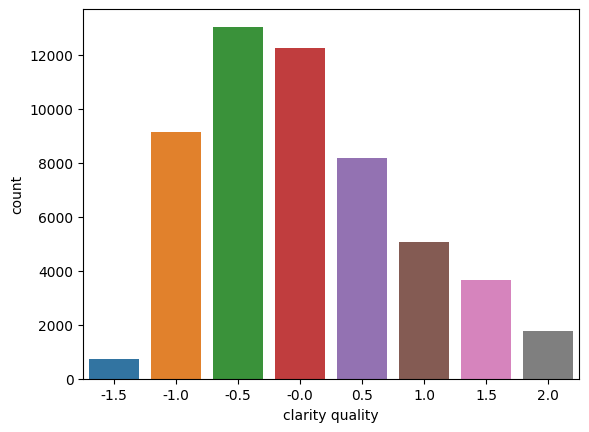

In [31]:
# Tal como indica la fuente, los diamantes de máxima calidad son muy raros. Hay menos, todavía, de la peor calidad
sns.countplot(x=df_diamonds['clarity quality'])
plt.show()


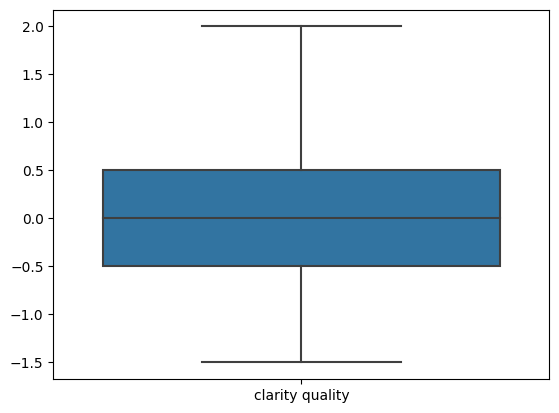

In [32]:
# Con todo, no hay "outliers"
ax = sns.boxplot(df_diamonds['clarity quality'])
ax.set_xticklabels(['clarity quality'])
plt.show()


## depth (percentage)

In [33]:
df_diamonds['depth (percentage)'].unique()


array([61.5, 59.8, 56.9, 62.4, 63.3, 62.8, 62.3, 61.9, 65.1, 59.4, 64. ,
       60.4, 62.2, 60.2, 60.9, 62. , 63.4, 63.8, 62.7, 61. , 58.1, 62.5,
       60.5, 60. , 60.7, 59.5, 58.2, 64.1, 60.8, 61.8, 61.2, 61.1, 65.2,
       58.4, 63.1, 61.6, 59.3, 62.6, 63. , 63.2, 62.1, 61.4, 62.9, 63.7,
       59.2, 59.9, 57.9, 55.1, 57.5, 66.3, 61.7, 58.8, 64.5, 65.3, 59.6,
       64.4, 65.7, 63.6, 61.3, 60.1, 60.3, 58. , 64.6, 59.7, 57.8, 67.9,
       60.6, 57.2, 64.2, 65.8, 67.4, 59. , 63.5, 67.3, 58.7, 66.4, 68.1,
       63.9, 55. , 58.6, 64.3, 58.5, 65. , 56. , 58.3, 53.1, 64.9, 59.1,
       58.9, 66.7, 57.7, 65.4, 53.3, 53. , 67.8, 66.1, 55.8, 67.6, 68.2,
       65.5, 67.7, 69.5, 56.6, 56.3, 66.9, 66. , 67. , 57.6, 67.1, 65.6,
       64.8, 69.3, 66.2, 55.4, 66.8, 64.7, 66.6, 55.9, 57.3, 57.4, 68.3,
       68.5, 56.2, 65.9, 56.5, 56.1, 66.5, 68.4, 69.7, 57.1, 68.7, 56.7,
       68.6, 71.6, 43. , 68.8, 67.5, 69. , 55.2, 68.9, 69.6, 57. , 56.4,
       56.8, 44. , 67.2, 70.1, 71.3, 70.6, 69.8, 71

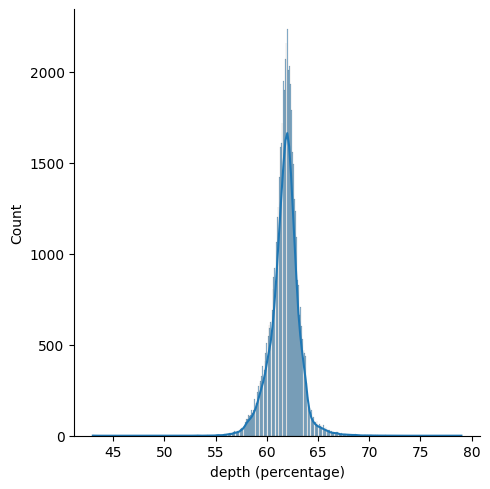

In [34]:
# Si no fuera porque el grueso de los números se encuentra en el centro, se asemejaría bastante a una distribución normal
sns.displot(df_diamonds['depth (percentage)'], kde=True)
plt.show()


### "Outliers" tratados en: "Desglose por múltiples variables"

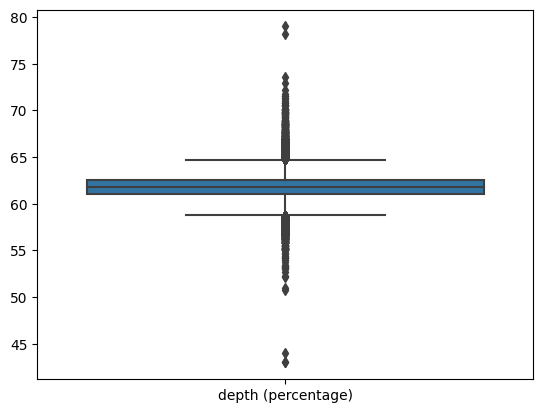

In [35]:
# A consecuencia de ello, hay muchos "outliers". Se nota la concentración en el centro
ax = sns.boxplot(df_diamonds['depth (percentage)'])
ax.set_xticklabels(['depth (percentage)'])
plt.show()


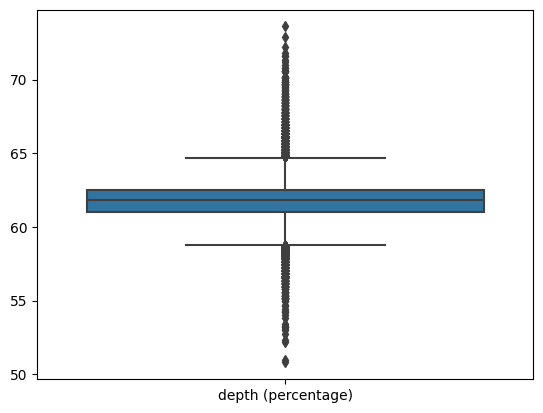

In [36]:
# Liquidamos esos cuatro "outliers" exageradamente altos
df_diamonds = df_diamonds.drop(df_diamonds[(df_diamonds['depth (percentage)'] > 75) | (df_diamonds['depth (percentage)'] < 45)].index)

ax = sns.boxplot(df_diamonds['depth (percentage)'])
ax.set_xticklabels(['depth (percentage)'])
plt.show()


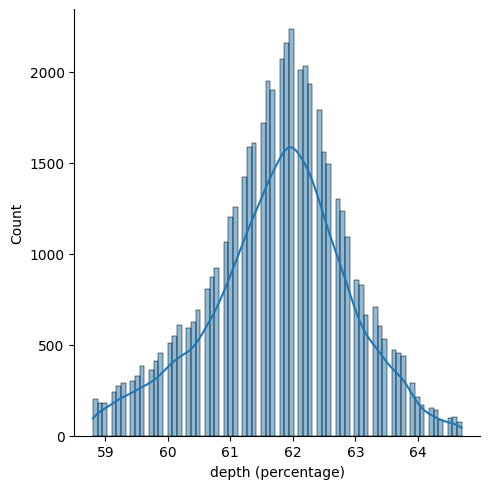

In [37]:
# Repetimos la gráfica de densidad, pero, esta vez, filtramos los valores atípicos para una mejor visualización
q3, q1 = np.percentile(df_diamonds['depth (percentage)'], [75, 25])
iqr = q3 - q1

df_depth_filtered = df_diamonds[(df_diamonds['depth (percentage)'] <= q3 + 1.5*iqr) & (df_diamonds['depth (percentage)'] >= q1 - 1.5*iqr)]

sns.displot(df_depth_filtered['depth (percentage)'], kde=True)
plt.show()


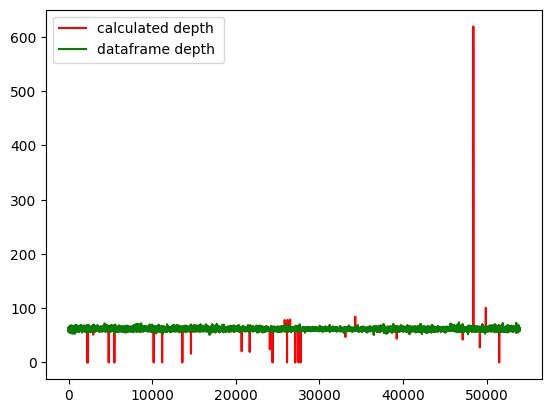

In [38]:
# Según el autor del "dataset" en Kaggle, la variable "depth (percentage)" sale de dividir "depth (millimeters)" por la media de "lenght (millimeters)" y "width (millimeters)"
# Por tanto, si hacemos la operación, el resultado debería coincidir con la columna de "depth (percentage)"
# Notamos que no coinciden, y que la versión incluida en el "dataset" parece no tener en cuenta varios valores que se considerarían my atípicos
# Para futuras pruebas de modelo, quizá convendrá tener en cuenta los valores calculados en lugar de los que vienen dados por defecto
calculated_depth = (df_diamonds['depth (millimeters)'] / ((df_diamonds['lenght (millimeters)']+df_diamonds['width (millimeters)']) / 2)) * 100
depth_comparison = pd.DataFrame({'calculated depth ': calculated_depth, 'dataframe depth': df_diamonds['depth (percentage)']})

depth_comparison.plot(kind='line', color=['red', 'green'])
plt.show()


## table (percentage)

In [39]:
df_diamonds['table (percentage)'].unique()


array([55. , 61. , 65. , 58. , 57. , 56. , 54. , 62. , 59. , 63. , 60. ,
       55.3, 69. , 53. , 64. , 56.4, 60.5, 67. , 52. , 55.8, 66. , 70. ,
       68. , 54.4, 57.1, 53.6, 54.8, 54.2, 54.9, 56.7, 53.9, 57.8, 54.1,
       55.1, 51. , 58.1, 56.9, 56.5, 53.7, 60.7, 56.2, 56.6, 56.1, 56.3,
       57.2, 57.5, 60.9, 59.8, 62.3, 60.1, 55.9, 50.1, 62.2, 54.5, 55.7,
       53.4, 54.7, 58.8, 59.4, 62.5, 54.3, 60.6, 55.2, 58.6, 49. , 50. ,
       54.6, 62.6, 57.7, 56.8, 57.9, 60.3, 55.6, 59.5, 57.4, 62.4, 60.4,
       53.3, 60.2, 60.8, 58.5, 57.6, 43. , 59.9, 63.5, 57.3, 61.4, 58.3,
       55.4, 58.2, 53.5, 59.7, 55.5, 58.7, 53.8, 59.1, 53.2, 59.3, 61.1,
       51.6, 95. , 61.2, 59.2, 58.4, 53.1, 52.8, 44. , 61.3, 61.9, 61.8,
       59.6, 61.5, 58.9, 64.3, 62.8, 71. , 52.4, 63.3, 61.7, 64.2, 73. ,
       65.4, 63.4, 62.1, 79. , 76. , 61.6])

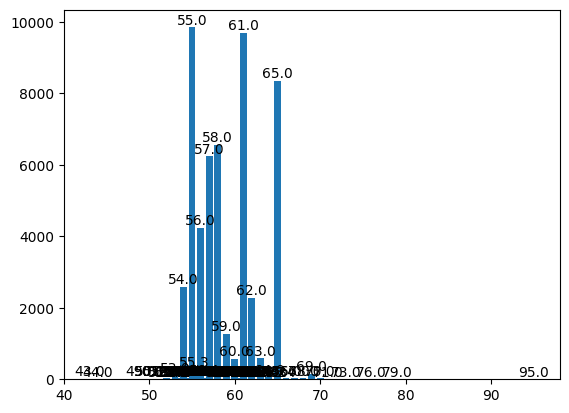

In [40]:
# Vemos que la inmensa mayoría se encuentran entre 50% y 65%, con números distintos, y que hay unos pocos valores que se repiten mucho
# Detectamos también un "outlier" flagrante del 95%
barplot = plt.bar(x=df_diamonds['table (percentage)'].unique(), height=df_diamonds['table (percentage)'].value_counts())
plt.bar_label(barplot, labels=df_diamonds['table (percentage)'].unique(), label_type='edge')
plt.show()


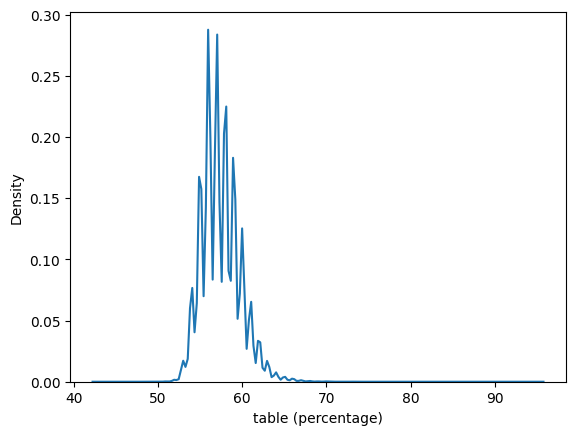

In [41]:
# Visualizamos su gráfica de densidad
sns.kdeplot(df_diamonds['table (percentage)'])
plt.show()


### "Outliers" tratados en: "Desglose por múltiples variables"

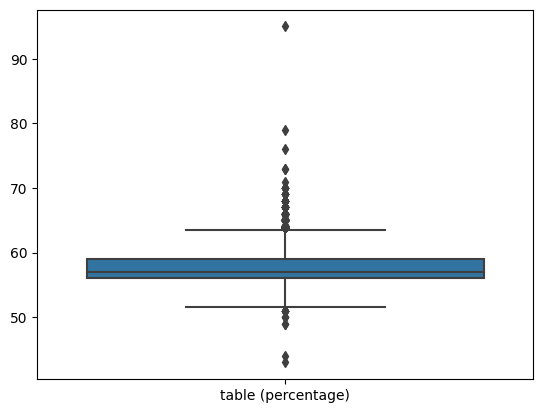

In [42]:
# Como es de preveer hay muchos "outliers", sobre todo por la parte superior, y una concentración importante entre 55% y 60%
ax = sns.boxplot(df_diamonds['table (percentage)'])
ax.set_xticklabels(['table (percentage)'])
plt.show()


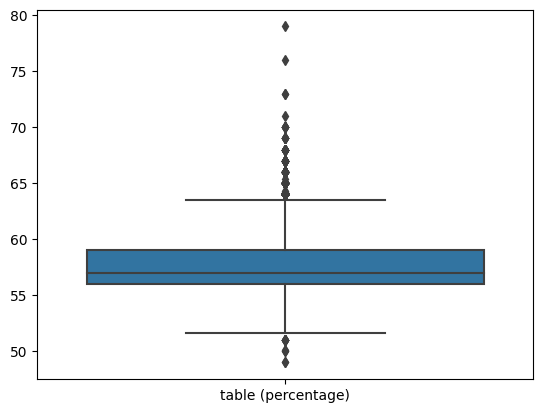

In [43]:
# Hay un solo valor muy alto y dos muy bajos. Nos podemos permitir eliminarlos
df_diamonds = df_diamonds.drop(df_diamonds[(df_diamonds['table (percentage)'] > 90) | (df_diamonds['table (percentage)'] < 45)].index)

ax = sns.boxplot(df_diamonds['table (percentage)'])
ax.set_xticklabels(['table (percentage)'])
plt.show()


## price (dollars) - target

In [44]:
# Esta es la columna "target"
df_diamonds['price (dollars)'].unique()


array([ 326,  327,  334, ..., 2753, 2755, 2756], dtype=int64)

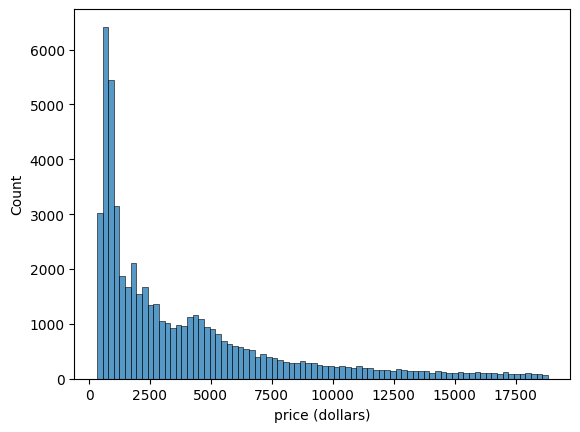

In [45]:
# Hay muchos diamantes con un precio "asequible", y cada vez menos a medida que se encarece
sns.histplot(df_diamonds['price (dollars)'])
plt.show()


### "Outliers" tratados - "target"

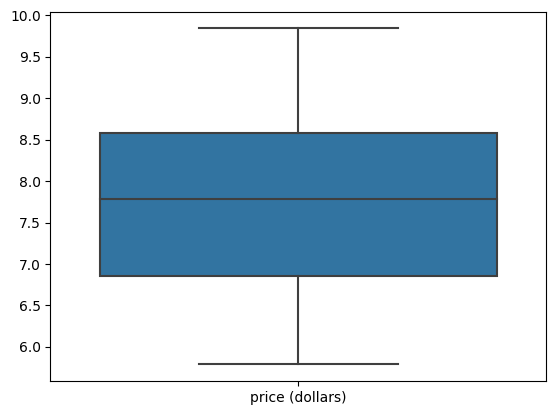

In [46]:
# Tiene valores atípicos en los precios superiores, y los números son muy altos comparados con el resto de columnas
# Le aplicamos un logaritmo para centrarlo, reducirlo y quitar los "outliers" sin eliminar realmente nada del "target"
df_diamonds['price (dollars)'] = np.log(df_diamonds['price (dollars)'])

ax = sns.boxplot(df_diamonds['price (dollars)'])
ax.set_xticklabels(['price (dollars)'])
plt.show()


## lenght (millimeters)

In [47]:
df_diamonds['lenght (millimeters)'].unique()


array([ 3.95,  3.89,  4.05,  4.2 ,  4.34,  3.94,  4.07,  3.87,  4.  ,
        4.25,  3.93,  3.88,  4.35,  3.79,  4.38,  4.31,  4.23,  4.21,
        4.26,  3.85,  4.39,  4.44,  3.97,  4.28,  3.96,  4.04,  4.01,
        3.92,  4.06,  3.83,  4.29,  4.13,  4.49,  3.99,  4.19,  4.24,
        4.36,  4.33,  4.02,  4.45,  3.91,  4.3 ,  4.43,  4.54,  4.78,
        4.15,  4.08,  4.03,  4.65,  4.22,  5.7 ,  6.45,  5.68,  5.81,
        5.85,  5.71,  6.27,  5.77,  5.97,  5.8 ,  6.  ,  5.94,  5.87,
        5.9 ,  6.14,  5.38,  5.96,  6.16,  5.73,  5.98,  5.72,  6.01,
        5.64,  5.57,  5.63,  5.65,  6.09,  5.56,  6.11,  6.03,  5.89,
        5.69,  5.62,  5.88,  5.52,  5.74,  5.53,  5.78,  5.83,  5.66,
        5.82,  5.79,  5.92,  5.39,  5.33,  6.83,  5.41,  5.25,  5.24,
        5.67,  5.61,  5.76,  6.05,  5.6 ,  5.19,  5.84,  6.39,  5.34,
        5.14,  5.11,  5.54,  6.07,  6.29,  6.31,  6.49,  5.28,  5.48,
        5.55,  6.41,  6.02,  5.91,  6.17,  6.61,  5.12,  6.19,  5.43,
        5.99,  5.95,

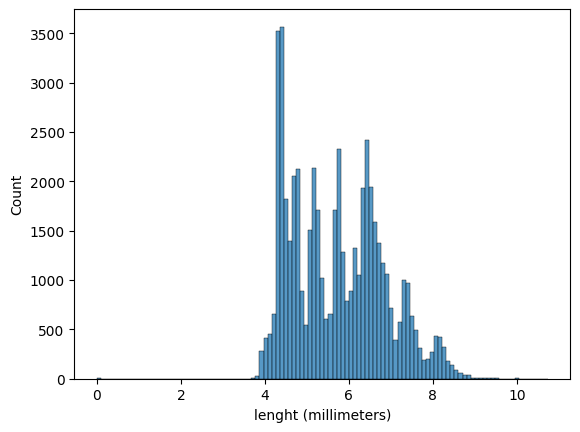

In [48]:
# Hay muchos valores únicos, así que usamos un histograma
# Claramente ese valor cercano a cero es un "outlier"
# Hay, además, unos pocos valores muy altos, cercanos a 10
sns.histplot(df_diamonds['lenght (millimeters)'])
plt.show()


In [49]:
# Si miramos esos ceros, vemos que, salvo uno, tampoco tenen width ni depth
df_diamonds[df_diamonds['lenght (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)
11182,0.067659,1.0,0.5,-1.0,61.6,56.0,8.507951,0.0,6.62,0.0
11963,0.000000,0.0,-0.5,-0.0,63.3,53.0,8.544614,0.0,0.00,0.0
15951,0.131028,-1.0,0.0,0.5,57.5,67.0,8.761080,0.0,0.00,0.0
24520,0.444686,1.0,0.0,-0.0,62.2,54.0,9.457200,0.0,0.00,0.0
26243,0.182322,0.5,1.5,1.5,62.1,59.0,9.660524,0.0,0.00,0.0
27429,0.810930,0.5,-0.5,-1.0,62.8,59.0,9.800014,0.0,0.00,0.0
49556,-0.342490,-0.5,0.5,-1.0,64.1,60.0,7.663877,0.0,0.00,0.0


In [50]:
# Como esas tres variables son probablemente las que más influyen en el precio, eliminamos directamente los diamantes que solo tienen ceros para mayor precisión
df_diamonds = df_diamonds.drop(df_diamonds[(df_diamonds['lenght (millimeters)'] == 0) 
                                & (df_diamonds['width (millimeters)'] == 0)
                                & (df_diamonds['depth (millimeters)'] == 0)
                                            ].index
                                )

df_diamonds[df_diamonds['lenght (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)
11182,0.067659,1.0,0.5,-1.0,61.6,56.0,8.507951,0.0,6.62,0.0


In [51]:
# En cuanto al restante, comprobamos la relación entre las columnas "lenght" y "width"
# Como los diamantes son más o menos circulares, a priori, los números de "lenght" y "width" son bastante similares
# Fuente: https://www.diamondonnet.com/knowledges/help?sword=Length%20To%20Width%20Ratio
df_diamonds[['lenght (millimeters)','width (millimeters)']].head()


,lenght (millimeters),width (millimeters)
0,3.95,3.98
1,3.89,3.84
2,4.05,4.07
3,4.20,4.23
4,4.34,4.35


In [52]:
# Tanto es así que, excluyendo ese cero y redondeados, son exactamente iguales todos
all(df_diamonds['lenght (millimeters)'].drop(11182).apply(lambda x: round(x))) == all(df_diamonds['width (millimeters)'].drop(11182).apply(lambda x: round(x)))


True

In [53]:
# Suponemos, pues, que para ese diamente con cero son el mismo
# Por tanto, asignamos a ese cero la cifra correspondiente de la columna "width"
# Seguidamente, aplicamos el logaritmo
df_diamonds.loc[df_diamonds.index == 11182, 'lenght (millimeters)'] = 6.62
df_diamonds['lenght (millimeters)'] = np.log(df_diamonds['lenght (millimeters)'])

df_diamonds['lenght (millimeters)'].head()


0    1.373716
1    1.358409
2    1.398717
3    1.435085
4    1.467874
Name: lenght (millimeters), dtype: float64

### "Outliers" tratados

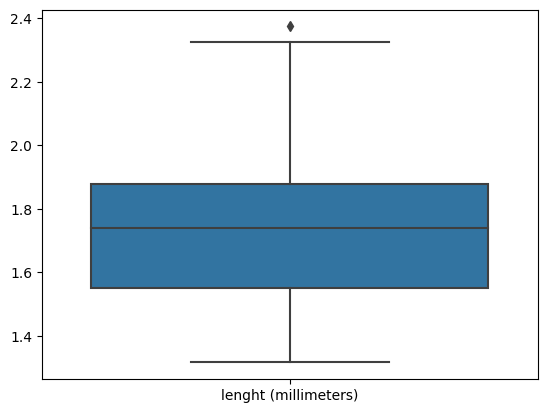

In [54]:
# Comprobamos que ya no quedan "outliers" por debajo de la mediana, y que queda uno por encima
ax = sns.boxplot(df_diamonds['lenght (millimeters)'])
ax.set_xticklabels(['lenght (millimeters)'])
plt.show()


In [55]:
# Sabemos que, por lo general, al tratarse de diamantes prácticamente circulares, el "lenght" y el "width" suelen ser muy parecidos
# Por tanto, imputamos ese valor atípico de "lenght" al "width" correspondiente para librarnos de él
q3, q1 = np.percentile(df_diamonds['lenght (millimeters)'], [75, 25])
iqr = q3 - q1

df_diamonds.loc[df_diamonds['lenght (millimeters)'] > q3 + 1.5*iqr, 'lenght (millimeters)'] = 2.355178


## width (millimeters)

In [56]:
df_diamonds['width (millimeters)'].unique()


array([ 3.98,  3.84,  4.07,  4.23,  4.35,  3.96,  4.11,  3.78,  4.05,
        4.28,  3.9 ,  4.37,  3.75,  4.42,  4.34,  4.29,  4.26,  4.27,
        4.3 ,  3.92,  4.43,  4.47,  4.01,  3.94,  3.97,  3.99,  4.03,
        4.06,  4.08,  3.85,  4.31,  4.16,  4.51,  4.5 ,  4.55,  4.02,
        4.24,  4.38,  3.95,  4.48,  3.89,  3.88,  4.33,  4.32,  4.59,
        4.84,  4.22,  4.  ,  4.25,  4.13,  4.09,  4.04,  4.12,  4.67,
        5.72,  6.33,  5.67,  5.73,  5.85,  5.9 ,  5.76,  5.95,  5.78,
        5.93,  5.75,  5.96,  5.79,  5.87,  5.8 ,  5.81,  6.11,  5.43,
        6.  ,  5.84,  6.12,  5.82,  5.74,  5.94,  6.07,  5.69,  5.83,
        5.61,  5.53,  5.58,  5.59,  5.97,  6.09,  5.99,  5.86,  5.68,
        5.65,  5.55,  5.77,  5.91,  5.56,  5.89,  5.92,  6.03,  5.44,
        5.37,  5.88,  6.9 ,  5.62,  5.27,  5.26,  5.7 ,  5.64,  5.63,
        5.71,  5.51,  5.22,  6.36,  5.54,  5.66,  6.2 ,  5.18,  5.15,
        6.1 ,  6.21,  6.22,  6.45,  6.01,  5.3 ,  5.41,  5.52,  6.27,
        6.05,  6.06,

### "Outliers" tratados

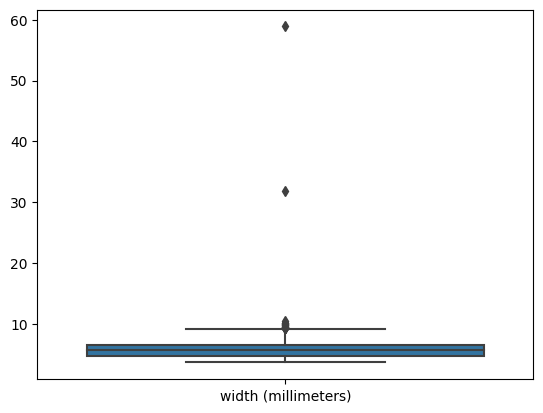

In [57]:
# En este caso están extremadamente concentrados, si bien hay unos pocos valores, poquísimos, superiores a 10
ax = sns.boxplot(df_diamonds['width (millimeters)'])
ax.set_xticklabels(['width (millimeters)'])
plt.show()


In [58]:
# Hay dos valores exageradamente altos. Los borramos. Con los que hemos eliminado antes en "lenght", ya no quedan ceros tampoco en "width"
df_diamonds = df_diamonds.drop(df_diamonds[df_diamonds['width (millimeters)'] > 30].index)

df_diamonds[df_diamonds['width (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)


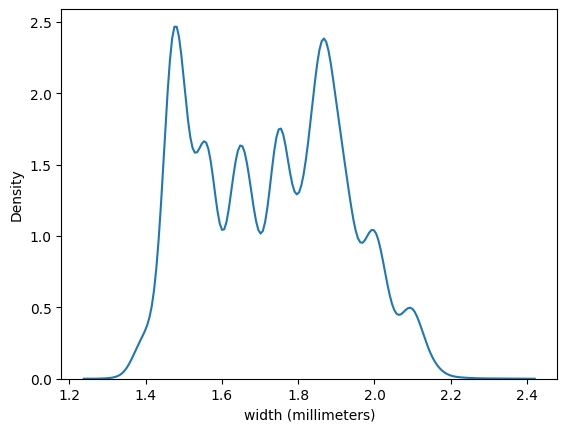

In [59]:
# Por tanto, podemos aplicar el logaritmo
df_diamonds['width (millimeters)'] = np.log(df_diamonds['width (millimeters)'])

sns.kdeplot(df_diamonds['width (millimeters)'])
plt.show()


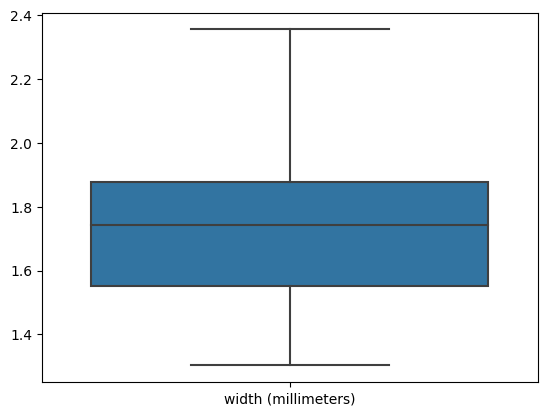

In [60]:
# Con lo hecho, ya no quedan valores atípicos
ax = sns.boxplot(df_diamonds['width (millimeters)'])
ax.set_xticklabels(['width (millimeters)'])
plt.show()


## depth (millimeters)

In [61]:
df_diamonds['depth (millimeters)'].unique()


array([ 2.43,  2.31,  2.63,  2.75,  2.48,  2.47,  2.53,  2.49,  2.39,
        2.73,  2.46,  2.33,  2.71,  2.27,  2.68,  2.7 ,  2.66,  2.41,
        2.62,  2.59,  2.67,  2.4 ,  2.42,  2.44,  2.37,  2.52,  2.78,
        2.76,  2.61,  2.65,  2.79,  2.54,  2.64,  2.45,  2.72,  2.69,
        2.96,  2.58,  2.51,  2.56,  2.55,  2.87,  3.57,  3.52,  3.5 ,
        3.56,  3.72,  3.38,  3.4 ,  4.07,  3.66,  3.65,  3.58,  3.59,
        3.63,  3.69,  3.61,  3.6 ,  3.35,  3.67,  3.62,  3.87,  3.68,
        3.49,  3.47,  3.46,  3.7 ,  3.32,  3.93,  3.95,  3.64,  3.53,
        3.37,  3.43,  3.51,  3.54,  3.48,  3.55,  3.33,  3.3 ,  4.13,
        3.79,  3.24,  3.23,  4.08,  3.19,  3.94,  3.08,  3.31,  3.21,
        3.75,  3.18,  3.41,  4.03,  4.09,  3.22,  4.18,  3.76,  3.83,
        3.17,  3.44,  3.74,  3.8 ,  3.39,  3.88,  4.  ,  3.98,  3.85,
        3.96,  3.16,  3.78,  3.84,  4.33,  4.01,  3.45,  2.74,  2.95,
        2.8 ,  2.77,  2.9 ,  2.82,  3.77,  3.9 ,  3.73,  3.34,  3.86,
        3.89,  3.81,

In [62]:
# Empezamos por comprobar los ceros. Hay bastantes
df_diamonds[df_diamonds['depth (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)
2207,0.000000,0.5,0.0,-1.0,59.1,59.0,8.052615,1.879465,1.868721,0.0
2314,0.009950,0.5,-0.5,-1.5,58.1,59.0,8.060540,1.896119,1.887070,0.0
4791,0.095310,0.5,0.0,-1.0,63.0,59.0,8.215006,1.871802,1.867176,0.0
5471,0.009950,0.5,0.5,-1.0,59.2,58.0,8.252446,1.871802,1.867176,0.0
10167,0.405465,-0.5,0.0,-1.5,64.0,61.0,8.461892,1.967112,1.951608,0.0
11182,0.067659,1.0,0.5,-1.0,61.6,56.0,8.507951,1.890095,1.890095,0.0
13601,0.139762,1.0,0.0,-0.0,59.2,56.0,8.624073,1.928619,1.921325,0.0
24394,0.779325,0.5,-0.5,-1.0,59.4,61.0,9.443909,2.138889,2.134166,0.0
26123,0.810930,0.5,-1.0,-0.5,61.3,58.0,9.641928,2.142416,2.130610,0.0
27112,0.788457,0.5,-0.5,-0.5,61.2,59.0,9.756437,2.130610,2.124654,0.0


In [63]:
# Sabemos que el "depth (percentage)" se obtiene de dividir su altura total ("depth") por el diámetro
# Como tenemos el "lenght" y el "width", el diámetro se obtiene con la media de esas dos cifras
# Por tanto, podemos resolver esos ceros con una operación

df_diamonds.loc[df_diamonds['depth (millimeters)'] == 0, 'depth (millimeters)'] = df_diamonds['depth (percentage)'] / 100 * (df_diamonds['lenght (millimeters)']+df_diamonds['width (millimeters)']) / 2

df_diamonds[df_diamonds['depth (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)


### "Outliers" tratados en: "Desglose por múltiples variables"

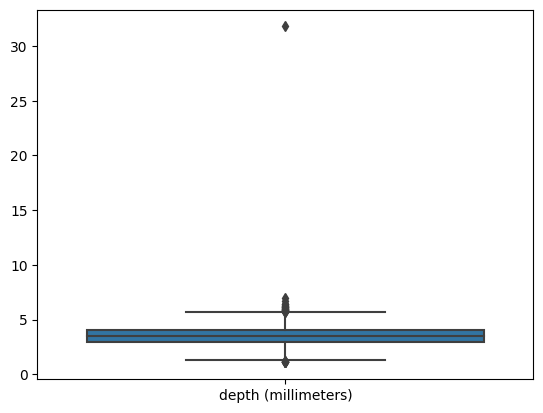

In [64]:
# Vemos que ya no hay ceros, que los valores están concentrados y que hay varios "outliers"; uno de ellos, muy alto
ax = sns.boxplot(df_diamonds['depth (millimeters)'])
ax.set_xticklabels(['depth (millimeters)'])
plt.show()


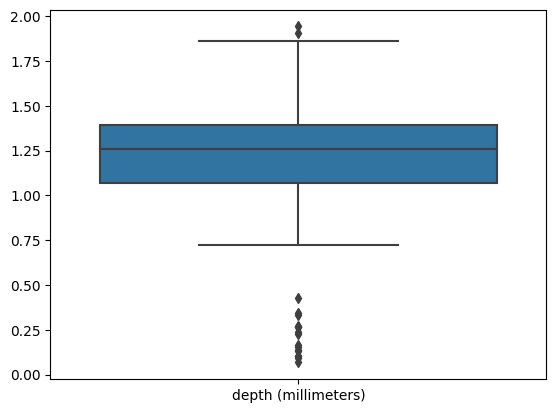

In [65]:
# Hay un solo valor exageradamente alto. Lo liquidamos y aplicamos el logaritmo para centrar la gráfica
df_diamonds = df_diamonds.drop(df_diamonds[df_diamonds['depth (millimeters)'] > 30].index)

df_diamonds['depth (millimeters)'] = np.log(df_diamonds['depth (millimeters)'])

ax = sns.boxplot(df_diamonds['depth (millimeters)'])
ax.set_xticklabels(['depth (millimeters)'])
plt.show()


# Desglose por múltiples variables

In [66]:
df_diamonds.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)
0,-1.469676,1.0,1.0,-1.0,61.5,55.0,5.786897,1.373716,1.381282,0.887891
1,-1.560648,0.5,1.0,-0.5,59.8,61.0,5.786897,1.358409,1.345472,0.837248
2,-1.469676,-0.5,1.0,0.5,56.9,65.0,5.789960,1.398717,1.403643,0.837248
3,-1.237874,0.5,-1.0,-0.0,62.4,58.0,5.811141,1.435085,1.442202,0.966984
4,-1.171183,-0.5,-1.5,-1.0,63.3,58.0,5.814131,1.467874,1.470176,1.011601


In [67]:
# La cuestión de los ceros ha quedado resuelta
df_diamonds.describe()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)
count,53777.000000,53777.000000,53777.000000,53777.000000,53777.000000,53777.000000,53777.000000,53777.000000,53777.000000,53777.000000
mean,-0.395024,0.452229,0.203042,0.025996,61.748521,57.457794,7.786946,1.727239,1.727844,1.244825
std,0.584427,0.557881,0.850572,0.823453,1.419471,2.224710,1.014397,0.193611,0.192198,0.194491
min,-1.609438,-1.000000,-1.500000,-1.500000,50.800000,49.000000,5.786897,1.316408,1.302913,0.067659
25%,-0.916291,0.000000,-0.500000,-0.500000,61.000000,56.000000,6.857514,1.549688,1.551809,1.068153
50%,-0.356675,0.500000,0.000000,0.000000,61.800000,57.000000,7.783641,1.740466,1.742219,1.261298
75%,0.039221,1.000000,1.000000,0.500000,62.500000,59.000000,8.580168,1.877937,1.877937,1.393766
max,1.472488,1.000000,1.500000,2.000000,73.600000,79.000000,9.842835,2.355178,2.355178,1.943049


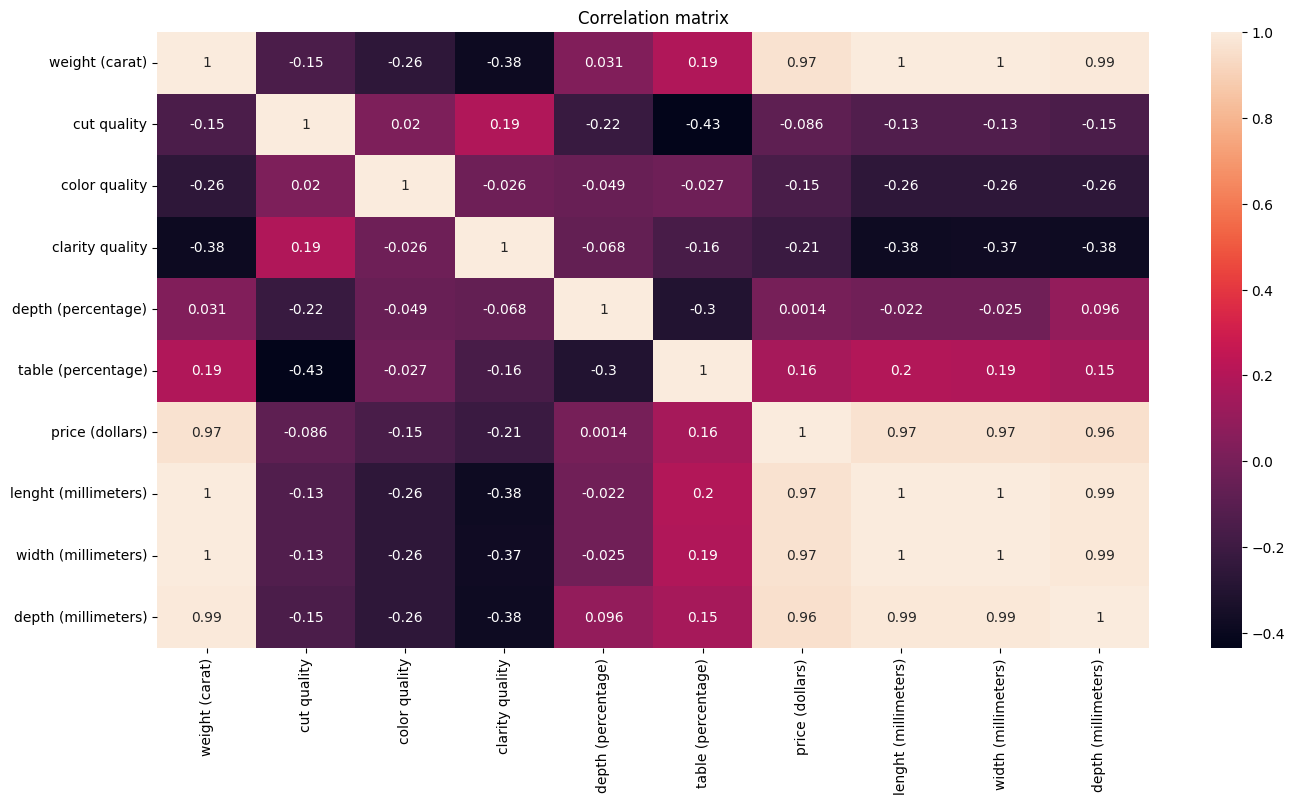

In [68]:
# Parece que lo que más influye en el precio son el tamaño ("lenght", "width" y "depth") y el peso ("weight") del diamante
# Respecto a las medidas específicas para diamantes ("depth" y "table" en %), se supone que mejorar en una suele requerir sacrificar la otra
# Eso a se debería que la "table" (parte plana superior del diamante) es más grande en los diamantes más anchos, y no en los de mayor altura ("depth")
# Asimismo, a mayor tamaño se pierde claridad (probablemente porque, con una mayor superficie, hay más probabilidad de imperfecciones)
# Hay otra correlación negativa entre la calidad del corte y el tamaño de la tabla, quizá porque cuanto mayor es la tabla más perceptibles son los cortes
# Hay que tener en cuenta al comparar que varias variables se han tipificado
plt.rc("figure", figsize=(16, 8))

corr = df_diamonds.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [69]:
plt.rc("figure", figsize=(6.4, 4.8))


## weight (carat), lenght (millimeters), width (millimeters), depth (millimeters) & price (dollars)

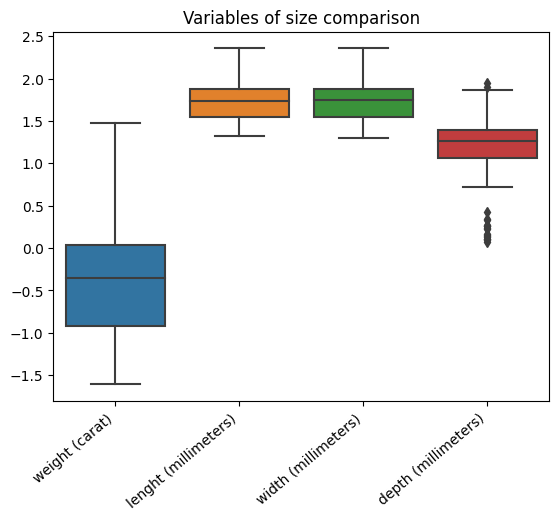

In [70]:
# Las cuatro primeras variables del título, las que vendrían a indicar el tamaño y el peso del diamante, están altísimamente correlacionadas
# Solo "depth" tiene "outliers"

items_list = ['weight (carat)', 'lenght (millimeters)', 'width (millimeters)', 'depth (millimeters)']
df_size = df_diamonds[items_list]

ax = sns.boxplot(df_size)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Variables of size comparison')
plt.show()


In [71]:
# Podemos utilizar un modelo de regresión para predecir esos "outliers" e imputarlos
# Como la correlación es tan extremadamente alta que podría decirse que son prácticamente la misma variable escalada, usamos "ridge"
q3, q1 = np.percentile(df_size['depth (millimeters)'], [75, 25])
iqr = q3 - q1

y_test = df_size[(df_size['depth (millimeters)'] > q3 + 1.5*iqr) | (df_size['depth (millimeters)'] < q1 - 1.5*iqr)]['depth (millimeters)']
y_train = df_size.drop(y_test.index)['depth (millimeters)']

X_train = df_size.drop(y_test.index)[['weight (carat)', 'lenght (millimeters)', 'width (millimeters)']]
X_test = df_size[(df_size['depth (millimeters)'] > q3 + 1.5*iqr) | (df_size['depth (millimeters)'] < q1 - 1.5*iqr)][['weight (carat)', 'lenght (millimeters)', 'width (millimeters)']]

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

df_depth = pd.DataFrame(data={'Original depth': y_test, 'Predicted depth': y_pred})

df_depth


,Original depth,Predicted depth
2207,0.102185,1.364820
2314,0.094416,1.360147
4791,0.163630,1.417956
5471,0.101417,1.373509
10167,0.226331,1.526123
11182,0.152119,1.392323
13601,0.130663,1.408743
14635,0.067659,1.391203
20694,0.425268,1.510586
21654,0.343590,1.480682


### "Outliers" tratados de "depth (millimeters)"

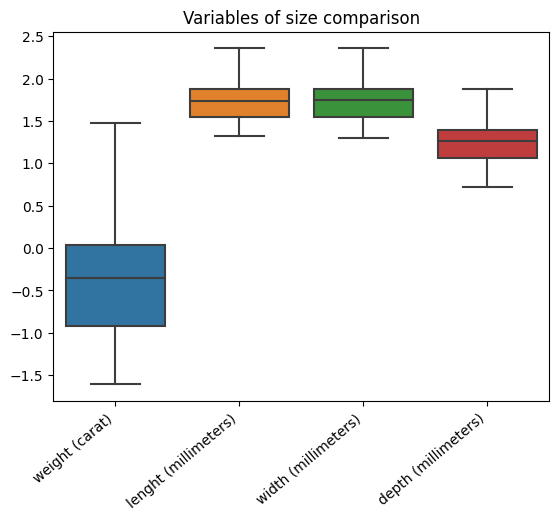

In [72]:
# Los valores atípicos de "depth" han sido neutralizados
for index in df_depth.index:
    df_diamonds.loc[index, 'depth (millimeters)'] = df_depth.loc[index, 'Predicted depth']

ax = sns.boxplot(df_diamonds[items_list])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Variables of size comparison')
plt.show()


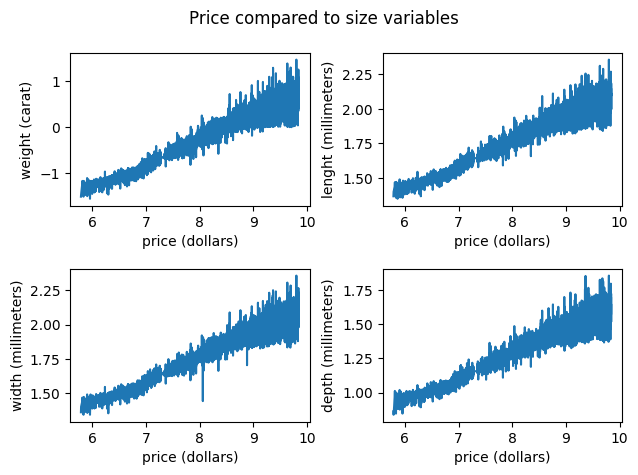

In [73]:
# Comparamos el precio con cada una de las variables relacionadas con el tamaño
# Aplicamos "errorbar=None" para que no compute los intervalos de confianza y sea más rápido
# Detectamos que, efectivamente, suben progresivamente con el precio de un modo similar
items_list.append('price (dollars)')

for index, element in enumerate(items_list[:-1], 1):
    plt.subplot(2, 2, index)
    sns.lineplot(data=df_diamonds, x=items_list[-1], y=element, errorbar=None)
    plt.legend('',frameon=False)
    plt.xlabel(xlabel=items_list[-1])
    plt.ylabel(ylabel=element)
plt.suptitle('Price compared to size variables')
plt.tight_layout()
plt.show()


## clarity quality, weight (carat), lenght (millimeters), width (millimeters) & depth (millimeters)

In [74]:
# La claridad del diamante (la falta de imperfecciones) tiene una importante correlación inversa (la misma) con las variable relacionadas con el tamaño
# Como las cuatro se comportan de un modo similar, para ver la tendencia las podemos simplificar en una sola
df_diamonds['size'] = (df_diamonds['weight (carat)'] 
                        + df_diamonds['lenght (millimeters)'] 
                        + df_diamonds['width (millimeters)'] 
                        + df_diamonds['depth (millimeters)']) / 4

df_diamonds['size'].unique()


array([0.54330317, 0.49512033, 0.54248286, ..., 1.11077845, 1.19906923,
       1.13429331])

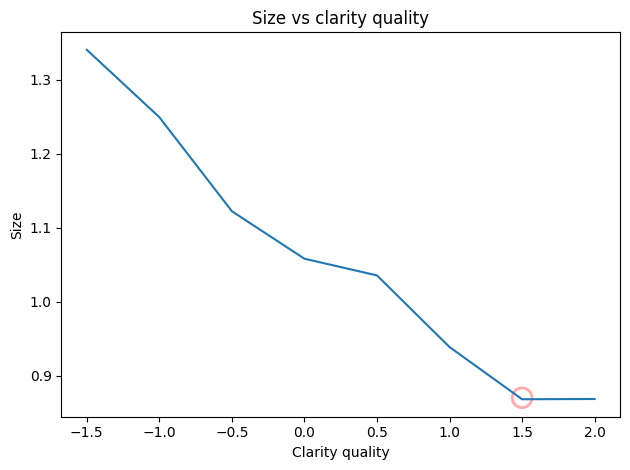

In [75]:
# Excepto con los de mayor "clarity quality" (marcado), el tamaño es cada vez más reducido
# Para futuras pruebas del modelo, cabría considerar la posibilidad de imputar los de calidad 2.0, que son pocos, al 1.5, con tal de que la tendencia se mantenga
fig, ax = plt.subplots()
ax.scatter(1.5, 0.87, s=200, edgecolor='#ff575a', lw=2, facecolor='none', alpha=0.5, zorder=1)
sns.lineplot(y=df_diamonds['size'], x=df_diamonds['clarity quality'], errorbar=None)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel(ylabel='Size')
plt.xlabel(xlabel='Clarity quality')
plt.title('Size vs clarity quality')
plt.tight_layout()
plt.show()


In [76]:
df_diamonds = df_diamonds.drop(columns='size')


## table (percentage) & depth (percentage)

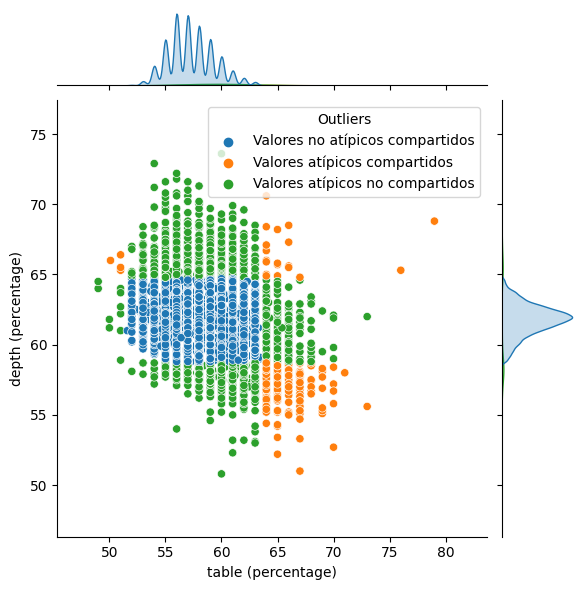

In [77]:
# La correlación más relevante de "table" es su correlación inversa con "depth (percentage)"
# Por tanto, para investigar sus valores atípicos las estudiamos a la vez
df_diamonds['Outliers'] = 'Valores no atípicos compartidos'

q3_table, q1_table = np.percentile(df_diamonds['table (percentage)'], [75, 25])
iqr_table = q3_table - q1_table
df_diamonds.loc[((df_diamonds['table (percentage)'] > q3_table + 1.5*iqr_table) | (df_diamonds['table (percentage)'] < q1_table - 1.5*iqr_table)), 'Outliers'] = 'Valores atípicos no compartidos'

q3_depth, q1_depth = np.percentile(df_diamonds['depth (percentage)'], [75, 25])
iqr_depth = q3_depth - q1_depth
df_diamonds.loc[((df_diamonds['depth (percentage)'] > q3_depth + 1.5*iqr_depth) | (df_diamonds['depth (percentage)'] < q1_depth - 1.5*iqr_depth)), 'Outliers'] = 'Valores atípicos no compartidos'

df_diamonds.loc[((df_diamonds['table (percentage)'] > q3_table + 1.5*iqr_table) | (df_diamonds['table (percentage)'] < q1_table - 1.5*iqr_table))
                & ((df_diamonds['depth (percentage)'] > q3_depth + 1.5*iqr_depth) | (df_diamonds['depth (percentage)'] < q1_depth - 1.5*iqr_depth)), 'Outliers'] = 'Valores atípicos compartidos'

sns.jointplot(data=df_diamonds, x='table (percentage)', y='depth (percentage)', hue='Outliers')
plt.show()


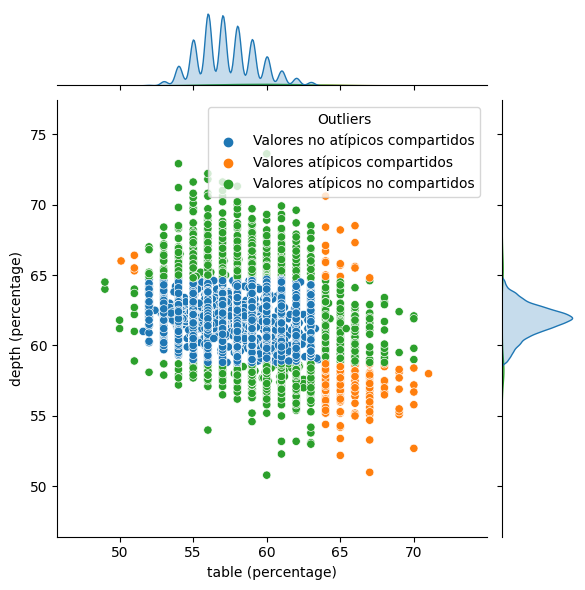

In [78]:
# Eliminamos esos cuatro valores que están muy alejados del resto del conjunto y repetimos la gráfica
df_diamonds = df_diamonds.drop(df_diamonds[df_diamonds['table (percentage)'] > 72].index)

sns.jointplot(data=df_diamonds, x='table (percentage)', y='depth (percentage)', hue='Outliers')
plt.show()


In [79]:
# Vemos que comparten algunos "outliers". Se trata de:
# a) los diamantes con mayor tabla y mayor profundidad (algunos);
# b) los diamantes con mayor tabla y menor profundidad (pocos);
# y c) los diamantes con menor tabla y mayor profundidad (muchos)
print(f"""Nº valores atípicos compartidos: {len(df_diamonds[df_diamonds['Outliers'] == 'Valores atípicos compartidos'])}
Nº valores atípicos no compartidos: {len(df_diamonds[df_diamonds['Outliers'] == 'Valores atípicos no compartidos'])}
Nº valores no atípicos compartidos: {len(df_diamonds[df_diamonds['Outliers'] == 'Valores no atípicos compartidos'])}""")


Nº valores atípicos compartidos: 212
Nº valores atípicos no compartidos: 2686
Nº valores no atípicos compartidos: 50875


### "Outliers" tratados de "depth (percentage)" y "table (percentage)"

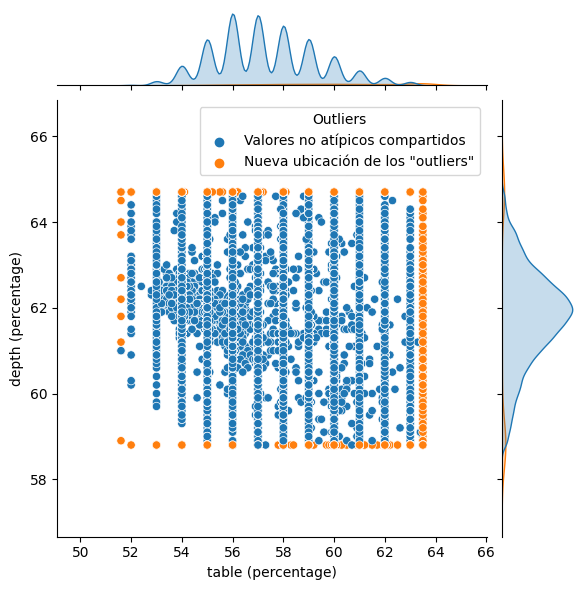

In [80]:
# Con esa información, deducimos que la correlación negativa (-0.3) se debe al peso de los "outliers" de mayor tabla y menor profundidad, que son más numerosos
# Esa correlación es especialmente importante porque es la única lo bastante alta como para vincular las dos variables, si el modelo acaba trabajando con una de ellas
# Con tal de preservar esa correlación, imputamos los valores atípicos a los máximos y mínimos de los no atípicos

max_depth = df_diamonds[df_diamonds['Outliers'] == 'Valores no atípicos compartidos']['depth (percentage)'].max()
min_depth = df_diamonds[df_diamonds['Outliers'] == 'Valores no atípicos compartidos']['depth (percentage)'].min()
max_table = df_diamonds[df_diamonds['Outliers'] == 'Valores no atípicos compartidos']['table (percentage)'].max()
min_table = df_diamonds[df_diamonds['Outliers'] == 'Valores no atípicos compartidos']['table (percentage)'].min()

df_diamonds.loc[df_diamonds['Outliers'] == 'Valores atípicos compartidos', 'Outliers'] = 'Valores atípicos no compartidos'

df_diamonds.loc[(df_diamonds['Outliers'] == 'Valores atípicos no compartidos') & (df_diamonds['depth (percentage)'] > max_depth), 'depth (percentage)'] = max_depth
df_diamonds.loc[(df_diamonds['Outliers'] == 'Valores atípicos no compartidos') & (df_diamonds['depth (percentage)'] < min_depth), 'depth (percentage)'] = min_depth
df_diamonds.loc[(df_diamonds['Outliers'] == 'Valores atípicos no compartidos') & (df_diamonds['table (percentage)'] > max_table), 'table (percentage)'] = max_table
df_diamonds.loc[(df_diamonds['Outliers'] == 'Valores atípicos no compartidos') & (df_diamonds['table (percentage)'] < min_table), 'table (percentage)'] = min_table

df_diamonds.loc[df_diamonds['Outliers'] == 'Valores atípicos no compartidos', 'Outliers'] = 'Nueva ubicación de los "outliers"'

sns.jointplot(data=df_diamonds, x='table (percentage)', y='depth (percentage)', hue='Outliers')
plt.show()


-0.3000648593272154


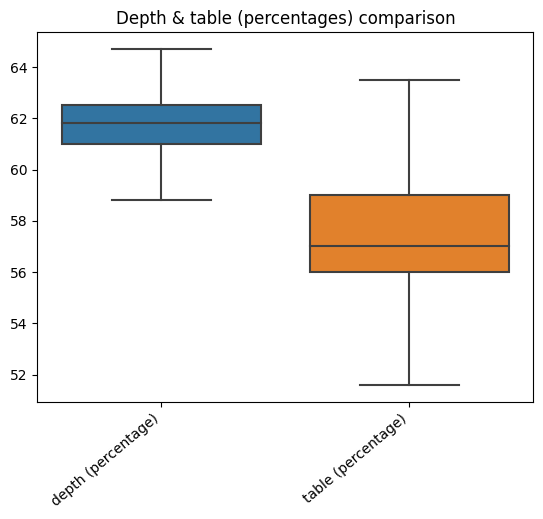

In [81]:
# La correlación inversa se mantiene en la misma cifra y ya no hay valores atípicos
df_diamonds = df_diamonds.drop(columns='Outliers')

print(df_diamonds['depth (percentage)'].corr(df_diamonds['table (percentage)']))

ax = sns.boxplot(df_diamonds[['depth (percentage)', 'table (percentage)']])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Depth & table (percentages) comparison')
plt.show()


In [82]:
# Finalmente, reducimos las cifras de ambas variables, que son muy elevadas en comparación al resto, para facilitarle el trabajo al modelo
for column in df_diamonds:
    if column == 'depth (percentage)' or column == 'table (percentage)':
        df_diamonds[column] = preprocessing.scale(df_diamonds[column], axis=0, copy=False)

df_diamonds[['depth (percentage)', 'table (percentage)']].head()


,depth (percentage),table (percentage)
0,-0.196709,-1.129628
1,-1.542094,1.648833
2,-2.333497,2.806525
3,0.515553,0.259602
4,1.227816,0.259602


## cut quality & table (percentage)

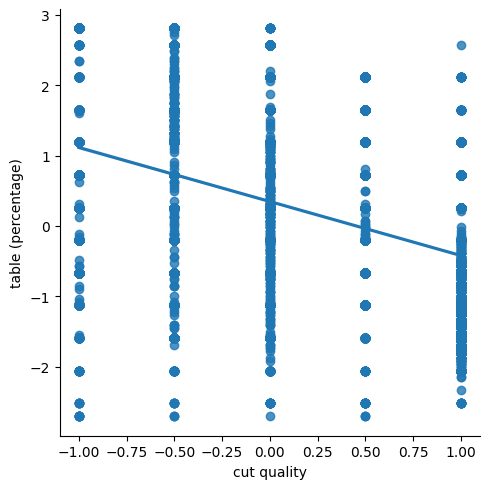

In [83]:
# Las variables "cut quality" y "table (percentage)", que es el tamaño de la parte plana en relación con su diámetro, tienen una alta correlación inversa
# Notamos que los valores de "table (percentage)" parecen concentrarse en un punto a medida que aumenta la calidad hasta desplazarse finalmente hacia valores negativos con los mejor cortados
# Con lo visto en el análisis univariante de "cut quality" y en la gráfica, hacemos esta suposición:
# que haya pocos valores de calidad menor influye en que la concentración de los números más altos sea superior, lo que hace caer la correlación
sns.lmplot(data=df_diamonds, x='cut quality', y='table (percentage)')
plt.show()


In [84]:
# Queremos fabricar más valores de "table (percentage)"" que tengan -1.0 de "cut quality" para comprobar si esa suposición es cierta
# Para ello, como no queremos que el resultado se aleje mucho la predicción de lo que ya existe y disponemos de pocos datos, iteraremos con un modelo de k vecinos
# Para asegurarnos, procuraremos que el número de valores resultantes se aceque a los 20000 que tiene el corte de mayor calidad
lower_cut = df_diamonds[df_diamonds['cut quality'] == -1.0]

new_cut = list(df_diamonds['cut quality'])
new_table = list(df_diamonds['table (percentage)'])
for _ in range(30):
    X_train, X_test, y_train, y_test = train_test_split(lower_cut.drop(columns='table (percentage)'), lower_cut['table (percentage)'], train_size=0.6, random_state=43)
    vecinos = KNeighborsRegressor()
    vecinos.fit(X_train, y_train)
    y_pred = vecinos.predict(X_test).tolist()
    new_cut += [-1.0] * len(y_pred)
    new_table += y_pred
cut_table_comparison = pd.DataFrame({'cut quality': new_cut, 'table (percentage)': new_table})

print(f"Nº de valores -1.0 originales: {len(df_diamonds[df_diamonds['cut quality'] == -1.0])}")
print(f"Nº de valores -1.0 tras la fabricación: {len(cut_table_comparison[cut_table_comparison['cut quality'] == -1.0])}")


Nº de valores -1.0 originales: 1588
Nº de valores -1.0 tras la fabricación: 20668


                    cut quality  table (percentage)
cut quality            1.000000           -0.404618
table (percentage)    -0.404618            1.000000


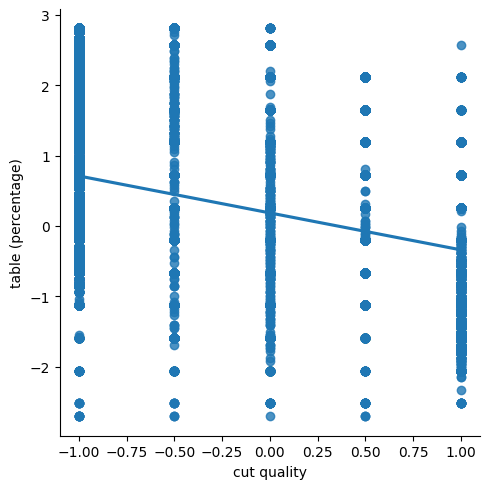

In [85]:
# Hemos creado muchos valores artificialmente, y, sin embargo, no hay grandes cambios
# No se alteran excesivamente la correlación ni la recta de regresión: la suposición no es cierta
print(cut_table_comparison.corr())

sns.lmplot(data=cut_table_comparison, x='cut quality', y='table (percentage)')
plt.show()


# Observaciones finales

In [86]:
# Reseteamos el índice para facilitar la visualización
df_diamonds = df_diamonds.reset_index(drop=True)


In [87]:
# Los números han quedado pequeños; salvo la "target", ninguna columna tiene valores excesivamente altos (todos están alrededor del 0)
df_diamonds.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)
0,-1.469676,1.0,1.0,-1.0,-0.196709,-1.129628,5.786897,1.373716,1.381282,0.887891
1,-1.560648,0.5,1.0,-0.5,-1.542094,1.648833,5.786897,1.358409,1.345472,0.837248
2,-1.469676,-0.5,1.0,0.5,-2.333497,2.806525,5.789960,1.398717,1.403643,0.837248
3,-1.237874,0.5,-1.0,-0.0,0.515553,0.259602,5.811141,1.435085,1.442202,0.966984
4,-1.171183,-0.5,-1.5,-1.0,1.227816,0.259602,5.814131,1.467874,1.470176,1.011601


In [88]:
# Se han borrado 23 filas respecto a las 53940 iniciales
df_diamonds.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53773 entries, 0 to 53772
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weight (carat)        53773 non-null  float64
 1   cut quality           53773 non-null  float64
 2   color quality         53773 non-null  float64
 3   clarity quality       53773 non-null  float64
 4   depth (percentage)    53773 non-null  float64
 5   table (percentage)    53773 non-null  float64
 6   price (dollars)       53773 non-null  float64
 7   lenght (millimeters)  53773 non-null  float64
 8   width (millimeters)   53773 non-null  float64
 9   depth (millimeters)   53773 non-null  float64
dtypes: float64(10)
memory usage: 4.1 MB


In [89]:
# Todas las columnas son numéricas y no hay ceros en las variables relacionadas con el tamaño
df_diamonds.describe()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)
count,53773.000000,53773.000000,53773.000000,53773.000000,5.377300e+04,5.377300e+04,53773.000000,53773.000000,53773.000000,53773.000000
mean,-0.395032,0.452337,0.203029,0.026017,-5.429924e-15,2.349404e-15,7.786950,1.727240,1.727846,1.245205
std,0.584448,0.557761,0.850579,0.823466,1.000009e+00,1.000009e+00,1.014435,0.193618,0.192204,0.193714
min,-1.609438,-1.000000,-1.500000,-1.500000,-2.333497e+00,-2.704089e+00,5.786897,1.316408,1.302913,0.722706
25%,-0.916291,0.000000,-0.500000,-0.500000,-5.924108e-01,-6.665514e-01,6.857514,1.549688,1.551809,1.068153
50%,-0.356675,0.500000,0.000000,0.000000,4.071148e-02,-2.034746e-01,7.783641,1.740466,1.742219,1.261298
75%,0.039221,1.000000,1.000000,0.500000,5.946935e-01,7.226790e-01,8.580356,1.877937,1.877937,1.396245
max,1.472488,1.000000,1.500000,2.000000,2.335780e+00,2.806525e+00,9.842835,2.355178,2.355178,1.873919


In [90]:
# No hay duplicados
df_diamonds[df_diamonds.duplicated()]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),price (dollars),lenght (millimeters),width (millimeters),depth (millimeters)


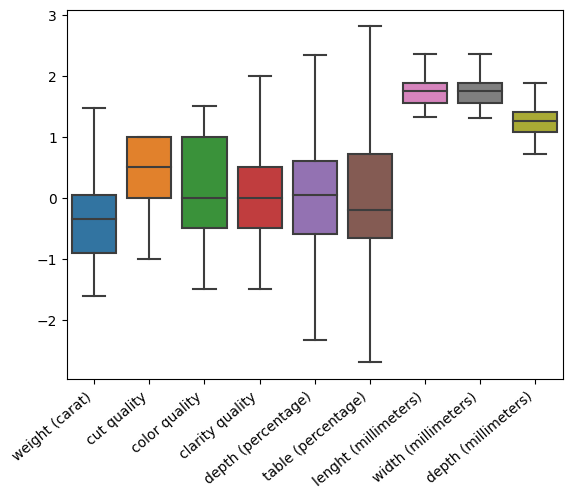

In [91]:
# No hay valores atípicos
ax = sns.boxplot(df_diamonds.drop(columns='price (dollars)'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()


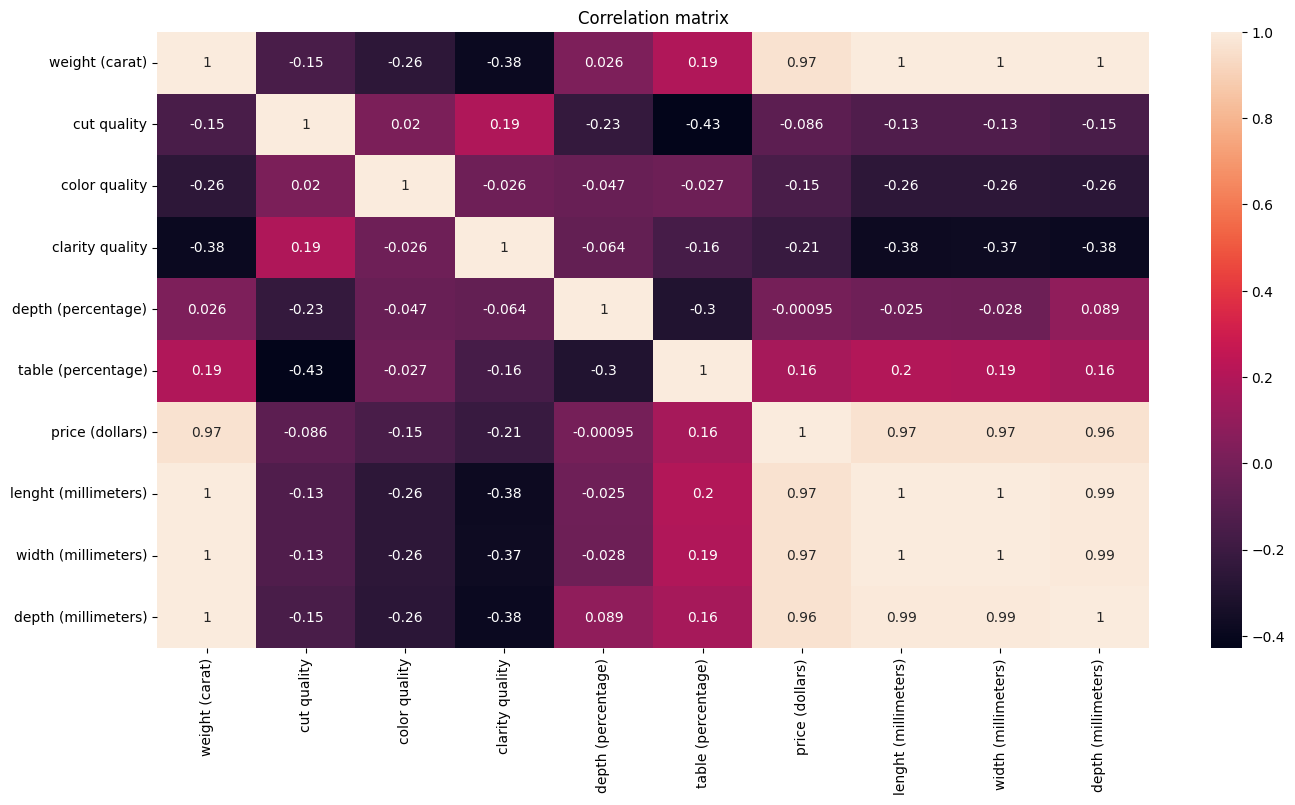

In [92]:
# La correlación ha cambiado un poco (por ejemplo, algunos valores se han convertido en 1) debido a la tipificación de los datos
# La tendencia general es similar y se han incorporado las variables que eran categóricas
plt.rc("figure", figsize=(16, 8))

corr = df_diamonds.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [93]:
plt.rc("figure", figsize=(6.4, 4.8))


In [94]:
# El "dataframe" está preparado para el modelaje. Lo exportamos
df_diamonds.to_csv(r'..\data\processed\processed_diamonds_1.csv', index=False)
